# Clasificación de Texto con BERT

### Recomendaciones
Asegurarse de tener GPU asociada a la instancia del Notebook para que el entrenamiento no demore mucho tiempo.


## Sobre BERT (Bidirectional Encoder Representations from Transformers)
[BERT](https://arxiv.org/abs/1810.04805)  y otras arquiteccturas basadasen Transformers han demostrado ser exitosos en diversidad de tareas de NLP
(natural language processing). Calculan representaciones del espacio vectorial del lenguaje natural que son adecuadas para su uso en modelos de deep learning. La familia de modelos BERT utiliza la Transformer encoder architecture para procesar cada token de texto de entrada en el contexto completo de todos los tokens antes y después.

Los modelos BERT generalmente se entrenan previamente en un gran corpus de texto y luego se ajustan para tareas específicas(fine-tuning).


#### Instalaciones Colab

In [ ]:
pip install tensorflow-text

In [ ]:
pip install tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 103.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 93.3 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=54456a9167eaf0f2199cd1053c2e9d7588e5b3273cd768dd2272e64b21c2cbae
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
  Attempting uninstall: keras


#### Realizo imports



In [ ]:
import os
import warnings

warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [ ]:
import datetime
import shutil

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
from sklearn.model_selection import train_test_split
from google.cloud import aiplatform
from official.nlp import optimization  # to create AdamW optmizer
import random
from sklearn.utils import resample

tf.get_logger().setLevel("ERROR")

To check if you have a GPU attached. Run the following.

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


### Veracity Classification
En este notebook se entrenara un modelo para clasificar noticias en español como *falsas* o *verdaderas*, basadas en su contenido.

Utilizaremos un dataset que contiene 60,000 noticias recopiladas eninternet.


### Cargando el Dataset



In [ ]:
df_chequeado = pd.read_csv('chequeado.csv')
df_chequeado.head(10)

,clasificacion,texto
0,1,No se divulgaron resultados oficiales previos ...
1,0,Se difundieron en redes sociales supuestos pri...
2,1,"En el balotaje 2023, las boletas con el número..."
3,0,"En el balotaje 2023, las boletas con el número..."
4,0,"Miles de usuarios denuncian que, durante la jo..."
5,1,"Miles de usuarios denuncian que, durante la jo..."
6,0,Sergio Massa pronunció la frase “voy a poder c...
7,0,Decenas de miles de usuarios comparten una pla...
8,0,Mural de Lionel Messi lleva escrito “Aguante M...
9,0,Aparece Mural de Lionel Messi en Rosario con l...


In [ ]:
df_chequeado.value_counts("clasificacion")

clasificacion
0    1770
1     857
dtype: int64

In [ ]:
df_data= pd.read_csv('data.csv')
df_data.head(10)

,clasificacion,texto
0,1,El presidente abre la puerta a unos comicios e...
1,1,"En un escrito, la abogada del Estado Rosa Marí..."
2,0,Este lunes y martes la Asamblea de Madrid acog...
3,1,Resulta evidente que la ley ha tenido algunos ...
4,1,"El hispanista, que ya ocupó un puesto simbólic..."
5,1,Empieza una intensa semana para el Ejecutivo c...
6,1,Núñez Feijóo guarda silencio pero Ayuso y Alme...
7,1,Los socialistas han remarcado que estos trabaj...
8,1,"El ministro de Inclusión, Seguridad Social y M..."
9,1,Izquierda Unida debate y aprueba este sábado s...


In [ ]:
df_data.value_counts("clasificacion")

clasificacion
1    70908
0    51868
dtype: int64

#### Separo en Train, Test & Validation

In [ ]:
# Divide el conjunto de datos en entrenamiento (60%), prueba (20%) y validación (20%)
train_chequeado, test_valid_data = train_test_split(df_chequeado, test_size=0.4, random_state=42)
test_chequeado, val_chequeado = train_test_split(test_valid_data, test_size=0.5, random_state=42)

# Imprime el tamaño de cada conjunto
print("Tamaño del conjunto de entrenamiento:", len(train_chequeado))
print("Tamaño del conjunto de prueba:", len(test_chequeado))
print("Tamaño del conjunto de validación:", len(val_chequeado))

Tamaño del conjunto de entrenamiento: 1576
Tamaño del conjunto de prueba: 525
Tamaño del conjunto de validación: 526


In [ ]:
val_chequeado.value_counts("clasificacion")

clasificacion
0    371
1    155
dtype: int64

Veamos algunas noticias:

In [ ]:
print(test_chequeado['texto'].iloc[1])
print("La noticia es:",test_chequeado['clasificacion'].iloc[1] == 1)

Tiempo Argentino: “[El salario mínimo] se incrementó un 2.389% desde junio de 2003”
La noticia es: False


In [ ]:
print(train_chequeado['texto'].iloc[1])
print("La noticia es:",train_chequeado['clasificacion'].iloc[1] == 1)

Las vacunas contra la COVID-19 contienen metales pesados y el cilantro es capaz de sacarlos del cuerpo humano
La noticia es: False


In [ ]:
print(val_chequeado['texto'].iloc[1])
print("La noticia es:",val_chequeado['clasificacion'].iloc[1] == 1)

Según Scioli, su gestión logró la “tasa más baja de desempleo”
La noticia es: True


In [ ]:
# Divide el conjunto de datos en entrenamiento (60%), prueba (20%) y validación (20%)
train_data, test_valid_data = train_test_split(df_data, test_size=0.4, random_state=42)
test_data, val_data = train_test_split(test_valid_data, test_size=0.5, random_state=42)

# Imprime el tamaño de cada conjunto
print("Tamaño del conjunto de entrenamiento:", len(train_data))
print("Tamaño del conjunto de prueba:", len(test_data))
print("Tamaño del conjunto de validación:", len(val_data))

Tamaño del conjunto de entrenamiento: 73665
Tamaño del conjunto de prueba: 24555
Tamaño del conjunto de validación: 24556


In [ ]:
val_data.value_counts("clasificacion")

clasificacion
1    14154
0    10402
dtype: int64

In [ ]:
print(train_data['texto'].iloc[1])
print("La noticia es:",train_data['clasificacion'].iloc[1] == 1)

Ábalos deja claro que “un Gobierno de colaboración no es un Gobierno de coalición”, pero dice que la decisión de que haya ministros de Podemos le corresponde al presidente.
La noticia es: True


In [ ]:
print(val_data['texto'].iloc[1])
print("La noticia es:",val_data['clasificacion'].iloc[1] == 1)

El Gobierno se niega a considerar los crímenes del GAL como terrorismo de Estado
La noticia es: False


In [ ]:
print(test_data['texto'].iloc[1])
print("La noticia es:",test_data['clasificacion'].iloc[1] == 1)

El dirigente confía en lograr un Consejo Nacional Electoral de consenso antes de las elecciones parlamentarias.
La noticia es: True


#### Transformo el dataset de Pandas a TensorFlow

In [ ]:
def pandas_to_tensorflow_dataset(df, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((df['texto'].values, df['clasificacion'].values))
    dataset = dataset.shuffle(buffer_size=len(df)).batch(batch_size)
    return dataset

In [ ]:
train_merged = pd.concat([train_data, train_chequeado], ignore_index=True)
test_merged = pd.concat([test_data, test_chequeado], ignore_index=True)
val_merged =pd.concat([val_data, val_chequeado], ignore_index=True)

In [ ]:
train_merged.to_csv('./train_merged.csv',index=False)
test_merged.to_csv('./test_merged.csv',index=False)
val_merged.to_csv('./val_merged.csv',index=False)

In [ ]:
# Imprime el tamaño de cada conjunto
print("Tamaño del conjunto de entrenamiento:", len(train_merged))
print("Tamaño del conjunto de prueba:", len(test_merged))
print("Tamaño del conjunto de validación:", len(val_merged))

Tamaño del conjunto de entrenamiento: 75241
Tamaño del conjunto de prueba: 25080
Tamaño del conjunto de validación: 25082


In [ ]:
batch_size = 16
train_ds = pandas_to_tensorflow_dataset(train_merged, batch_size=batch_size)
test_ds = pandas_to_tensorflow_dataset(test_merged, batch_size=batch_size)
val_ds = pandas_to_tensorflow_dataset(val_merged, batch_size=batch_size)


# Imprimir algunos ejemplos del conjunto de entrenamiento
for text, label in train_ds.take(1):
    print("Texto:")
    print(text)
    print("Categoría:")
    print(label)

Texto:
tf.Tensor(
[b'El president de la Generalitat valora como importante la reuni\xc3\xb3n con Rita Maestre. Sobre el caso Pegasus considera que ahora hay garant\xc3\xadas de que no se volver\xc3\xa1 a producir el espionaje, pero exige que se llegue al fondo del asunto.'
 b'La jueza del caso m\xc3\xa1ster cita como imputada a la hija de la asesora de Cifuentes que presion\xc3\xb3 a la URJC'
 b'M\xc3\xa1s de 40.000 militantes del Nueva Canarias eligen el 13 de junio a la persona que disputar\xc3\xa1 a Moreno el Gobierno de Andaluc\xc3\xada'
 b'Albert Rivera y Pablo Casado, en la sesi\xc3\xb3n de control, inauguran su nueva estrategia contra los presupuestos del Gobierno, que consiste en acusarlos de ilegales por no cumplir con la senda de gasto del 1,3%, actualmente en vigor.'
 b'El Pleno del Congreso aprueba los segundos Presupuestos del Gobierno de Jos\xc3\xa9 Mi\xc3\xb1ones en minor\xc3\xada y con el mismo respaldo que en 2017.'
 b'Ser\xc3\xa1 un gobierno de coalici\xc3\xb3n y pari

## Obtengo modelo de  TensorFlow Hub

En primer lugar cargaremos un modelo llamado Small BERT. El BERT pequeño tiene la misma arquitectura general que el BERT original, pero tiene menos bloques Transformer y/o más pequeños.

Algunos otros modelos BERT populares son BERT Base, ALBERT, BERT Experts, Electra. Consulte la sección de aprendizaje continuo al final de esta práctica de laboratorio para obtener más información.

Aparte de los modelos disponibles a continuación, hay [varias versiones](https://tfhub.dev/google/collections/transformer_encoders_text/1) de los modelos que son más grandes y pueden ofrecer una precisión aún mayor..

Cambiar la URL tfhub.dev es suficiente para probar otro de estos modelos.




### Elijo modelo BERT para hacer el fine-tunig

In [ ]:
# defining the URL of the smallBERT model to use
tfhub_handle_encoder = (
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/multi-cased-l-12-h-768-a-12/versions/4"
)

# defining the corresponding preprocessing model for the BERT model above
tfhub_handle_preprocess = (
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/multi-cased-preprocess/versions/3"
)

print(f"BERT model selected           : {tfhub_handle_encoder}")
print(f"Preprocess model auto-selected: {tfhub_handle_preprocess}")

BERT model selected           : https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/multi-cased-l-12-h-768-a-12/versions/4
Preprocess model auto-selected: https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/multi-cased-preprocess/versions/3



## Preprosamiento del modelo

Las entradas de texto deben transformarse en tokens numéricos y organizarse en varios tensores antes de ingresarloas al modelo BERT. TensorFlow Hub proporciona un modelo de preprocesamiento coincidente para cada uno de los modelos BERT discutidos anteriormente, que implementa esta transformación utilizando operaciones TF de la biblioteca TF.text.

Uso `hub.KerasLayer` para inicializar el preprocesamiento

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Pruebo el modelo en un texto para ver el output:

In [ ]:
text_test = ["La tierra es plana!"]
text_preprocessed = bert_preprocess_model(text_test)

print(f"Keys       : {list(text_preprocessed.keys())}")

# 1. input_word_ids is the ids for the words in the tokenized sentence
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')

# 2. input_mask is the tokens which we are masking (masked language model)
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')

# 3. input_type_ids is the sentence id of the input sentence.
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101 10159 19250 10196 48220   106   102     0     0     0     0     0]
Input Mask : [1 1 1 1 1 1 1 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


Se obtuvieron las 3 salidas del preprocesamiento que usa el modelo BERT (`input_words_id`, `input_mask` y `input_type_ids`).

- La entrada se trunca a 128 tokens.
- Los `input_type_ids` solo tienen un valor (0) porque se trata de una entrada de una sola oración. Para una entrada de varias oraciones, tendría un número para cada entrada.

El preprocesador de texto es un modelo de TensorFlow. Esto significa que en lugar de preprocesarlo por separado, podemos incluirlo como una capa en el código del modelo.

### Usando el modelo BERT

Observamos sus resultados:

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f"Loaded BERT: {tfhub_handle_encoder}")
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/multi-cased-l-12-h-768-a-12/versions/4
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[ 0.42469004  0.11756774  0.35674104 -0.25368872 -0.12178946  0.42079028
  0.16237035  0.07468537 -0.14108208  0.3013579  -0.28854537 -0.09433146]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[-0.6541104   0.14491536  0.01771995 ...  0.28348818  0.4475179
   0.32261994]
 [-0.33443767 -0.41056287  0.05437389 ...  0.51214427  0.20981394
   0.45502084]
 [-0.18967843  0.31747633  0.80963373 ...  0.65997964 -0.3565879
   0.338609  ]
 ...
 [-0.8397977   0.21424069 -0.03838331 ...  0.18782735  0.28920874
   0.23969042]
 [-0.6727521   0.14535972 -0.04213646 ...  0.22041477  0.31239825
   0.27802506]
 [-0.6468118   0.18051721 -0.02422649 ...  0.18819349  0.35489202
   0.30088276]]


Los modelos BERT devuelven un mapa con 3 claves importantes: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` para representar cada secuencia de entrada como un todo. La forma es `[batch_size, H]`.
- `sequence_output` representa cada token de entrada en el contexto. La forma es `[batch_size, seq_length, H]`.
- `encoder_outputs` son las activaciones intermedias de los bloques Transformador `L`. `outputs["encoder_outputs"][i]` es un tensor de forma `[batch_size, seq_length, 1024]` con las salidas del i-ésimo bloque Transformer, para `0 <= i < L`. El último valor de la lista es igual a `sequence_output`.

Para el ajuste fino, se usala matriz `pooled_output`.


### Definiendo el modelo


El modelo tendra las siguiente capas:
1. Input Layer
2. Pre-processing Layer
3. Encoder Layer
4. From the BERT output map, use pooled_output
5. Dropout layer
6. Dense layer with sigmoid activation

In [ ]:
def build_classifier_model(dropout_rate=0.1):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="texto")
    preprocessing_layer = hub.KerasLayer(
        tfhub_handle_preprocess, name="preprocessing"
    )
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(
        tfhub_handle_encoder, trainable=True, name="BERT_encoder"
    )
    outputs = encoder(encoder_inputs)
    net = outputs["pooled_output"]
    net = tf.keras.layers.Dropout(dropout_rate)(net)
    net = tf.keras.layers.Dense(1, activation="sigmoid", name="classifier")(net)
    return tf.keras.Model(text_input, net)

tf.Tensor([[0.3434986]], shape=(1, 1), dtype=float32)


In [ ]:
# Let's check that the model runs with the output of the preprocessing model.
dropout_rate = 0.15
classifier_model = build_classifier_model(dropout_rate)
bert_raw_result = classifier_model(tf.constant(text_test))
print(bert_raw_result)

tf.Tensor([[0.5972232]], shape=(1, 1), dtype=float32)


El modelo tiene la siguiente estructura:


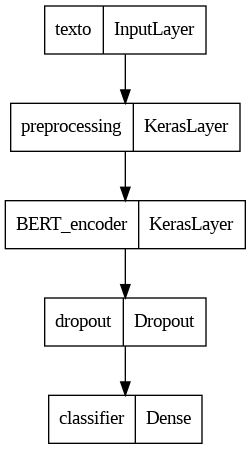

In [ ]:
tf.keras.utils.plot_model(classifier_model)

## Entrenando el Modelo


### Loss function

Dado que se trata de un problema de clasificación binaria se utilizará la función de pérdida `losses.BinaryCrossentropy`.


In [ ]:
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [tf.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]

### Optimizer


Para realizar ajustes, usaremos el optimizador con el que se entrenó originalmente a BERT: Adam optimizart. Este optimizador minimiza la pérdida de predicción y realiza la regularización mediante disminución de peso.


In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type="adamw",
)

### Cargando el Modelo BERT y entrenandolo

Compilo el modelo utilizando el optimizador, la pérdida y las métricas que se definieron anteriormente.

In [ ]:
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
print(f"Training model with {tfhub_handle_encoder}")
history = classifier_model.fit(
    x=train_ds, validation_data=val_ds, epochs=epochs
)

Training model with https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/multi-cased-l-12-h-768-a-12/versions/4
Epoch 1/5
4703/4703 [==============================] - 2718s 574ms/step - loss: 0.4442 - binary_accuracy: 0.7752 - precision: 0.7462 - recall: 0.9203 - val_loss: 0.4020 - val_binary_accuracy: 0.8100 - val_precision: 0.8139 - val_recall: 0.8648
Epoch 2/5
4703/4703 [==============================] - 2702s 574ms/step - loss: 0.3659 - binary_accuracy: 0.8295 - precision: 0.7928 - recall: 0.9504 - val_loss: 0.3937 - val_binary_accuracy: 0.8318 - val_precision: 0.7915 - val_recall: 0.9573
Epoch 3/5
4703/4703 [==============================] - 2700s 574ms/step - loss: 0.3307 - binary_accuracy: 0.8462 - precision: 0.8166 - recall: 0.9431 - val_loss: 0.3977 - val_binary_accuracy: 0.8335 - val_precision: 0.7928 - val_recall: 0.9588
Epoch 4/5
4703/4703 [==============================] - 2699s 574ms/step - loss: 0.2952 - binary_accuracy: 0.8594 - precision: 0.8

### Evaluando el Modelo


Veamos cómo funciona el modelo. Se devolverán dos valores. Loss (un número que representa el error, los valores más bajos son mejores) y Accuracy.

In [ ]:
metrics = classifier_model.evaluate(test_ds)

print(f"metrics: {metrics}")


1568/1568 [==============================] - 261s 167ms/step - loss: 0.4908 - binary_accuracy: 0.8123 - precision: 0.8091 - recall: 0.8807
metrics: [0.49082842469215393, 0.8122807145118713, 0.8090769648551941, 0.8806976079940796]


### Graficamos Loss y Accuracy a lo largo del tiempo


Basado en el objeto `History` devuelto por `model.fit()`. Se puede graficar la pérdida de entrenamiento y validación para comparar, así como la precisión del entrenamiento y la validación:

dict_keys(['loss', 'binary_accuracy', 'precision', 'recall', 'val_loss', 'val_binary_accuracy', 'val_precision', 'val_recall'])


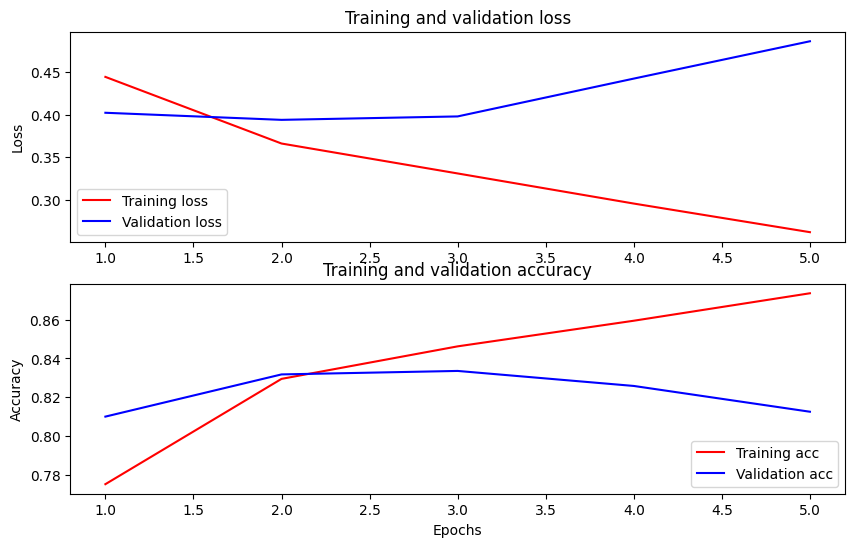

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict["binary_accuracy"]
val_acc = history_dict["val_binary_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, "r", label="Training loss")
# b is for "solid blue line"
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
# plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, "r", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

En este gráfico, las líneas rojas representan la pérdida y precisión del entrenamiento, y las líneas azules son la pérdida y precisión de la validación.

### Exportar modelo

Se guarda el modelo ajustado para su uso posterior.

In [ ]:
dataset_name = "veracity"
saved_model_path = "./{}_bert".format(dataset_name.replace("/", "_"))
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

EXPORT_PATH = os.path.join(saved_model_path, TIMESTAMP)

classifier_model.save(EXPORT_PATH, include_optimizer=False)

Recarguemos el modelo para que puedas probarlo junto con el modelo que aún está en la memoria.

In [ ]:
reloaded_model = tf.saved_model.load(EXPORT_PATH)

Aquí se puede probar el modelo en cualquier noticia que desee, simplemente agréguela a la variable de ejemplos a continuación.

In [ ]:
def print_my_examples(inputs, results):
    result_for_printing = [
        f"input: {inputs[i]:<30} : score: {results[i][0]:.6f}"
        for i in range(len(inputs))
    ]
    print(*result_for_printing, sep="\n")
    print()


examples = [
    "la tierra es plana!",
    "El presidente habla con su perro desde el mas alla",
    "Renuncio el ministro de economia",
    "Las vacunas son malas para la salud, tienen microchips que te controlan",
    "Milei es presidente",
]

original_results = classifier_model(tf.constant(examples))
print("Results del modelo en memoria:")
print_my_examples(examples, original_results)

Results del modelo en memoria:
input: la tierra es plana!            : score: 0.003334
input: El presidente habla con su perro desde el mas alla : score: 0.307698
input: Renuncio el ministro de economia : score: 0.003872
input: Las vacunas son malas para la salud, tienen microchips que te controlan : score: 0.007765
input: Milei es presidente            : score: 0.008708



## Aprendizaje continuo

En este notebook se selecciono Small BERT para entrenar nuestro clasificador de texto. Hay otros modelos BERT previamente entrenados que pueden encontrarse a continuación. Se considera experimentar con algunos de estos, considerado que cuanto más grande sea el modelo a ajustar, más tiempo llevará entrenarlo.

Los modelos son:
  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

Para mas detalles investigar la documentación del modelo en TensorFlow Hub.

Aparte de los modelos disponibles anteriormente, hay [varias versiones](https://tfhub.dev/google/collections/transformer_encoders_text/1) de los modelos que son más grandes y pueden ofrecer una precisión aún mayor, pero son demasiado grandes para ajustar en una sola GPU.

#### **Licencia**

Este notebook esta basado en la documentación oficial de Google para la clasificacion de textos utilizando BERT.

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License